In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../") # go to parent dir

In [3]:
import pandas as pd

In [4]:
PAST_FAKE_NEWS = pd.read_csv('../data/FakeHealth.tsv', sep='\t')
PAST_FAKE_NEWS = PAST_FAKE_NEWS[PAST_FAKE_NEWS['label']=='fake']
PAST_FAKE_NEWS.dropna(inplace=True)

In [5]:
!pip install gensim
!pip install scipy
!pip install pyLDAvis

You should consider upgrading via the '/data/isspek/FakeNewsDetectionFramework/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/data/isspek/FakeNewsDetectionFramework/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/data/isspek/FakeNewsDetectionFramework/venv/bin/python -m pip install --upgrade pip' command.


In [6]:
from gensim import matutils, models

In [7]:
merged_content = PAST_FAKE_NEWS['title'] + PAST_FAKE_NEWS['content']

print(merged_content.head(5))

0    Tiny implantable device short-circuits hunger ...
1    Probiotics could help millions of patients suf...
2    Yes Please to Yogurt and Cheese: The New Impro...
3    Cedars-Sinai Surgeon Uses New Device to Perfor...
4    Vitamin C May Reduce Harm to Infants’ Lungs Ca...
dtype: object


## Preprocessing

In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwords_en = stopwords.words('english')

def preprocess(text, stopwords_en=stopwords_en, lemmatizer=WordNetLemmatizer()):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub("\d+", " ", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text) #remove duplicated words in row
    splitted_text = text.split()
    splitted_text = [lemmatizer.lemmatize(text, 'v') for text in splitted_text] 
    splitted_text = [lemmatizer.lemmatize(text) for text in splitted_text] 
    condition = lambda content: content not in stopwords_en
    splitted_text = list(filter(condition, splitted_text))
    return splitted_text

In [9]:
cleaned_content = [preprocess(text) for text in merged_content]
cleaned_content = [ list(filter(lambda content: len(content) > 1, l)) for l in cleaned_content ]
print(cleaned_content[1])

['probiotic', 'could', 'help', 'million', 'patient', 'suffer', 'bipolar', 'disorderabout', 'million', 'people', 'diagnose', 'every', 'year', 'bipolar', 'disorder', 'psychiatric', 'condition', 'characterize', 'dramatic', 'shift', 'mood', 'depression', 'mania', 'currently', 'standard', 'treatment', 'include', 'combination', 'psychotherapy', 'prescription', 'medication', 'mood', 'stabilizer', 'antipsychotic', 'however', 'emerge', 'field', 'research', 'explore', 'use', 'probiotic', 'often', 'think', 'good', 'bacteria', 'potential', 'new', 'avenue', 'treatment', 'bipolar', 'psychiatric', 'mood', 'disorder', 'new', 'study', 'baltimore', 'sheppard', 'pratt', 'health', 'system', 'conduct', 'research', 'team', 'lead', 'faith', 'dickerson', 'find', 'probiotic', 'supplement', 'may', 'reduce', 'inflammation', 'gut', 'know', 'exacerbate', 'bipolar', 'disorder', 'probiotic', 'organism', 'non', 'pathogenic', 'bacteria', 'present', 'gut', 'flora', 'know', 'improve', 'overall', 'health', 'host', 'recen

In [10]:
import gensim

In [11]:
vocabulary = gensim.corpora.Dictionary(cleaned_content)
vocabulary.filter_extremes(no_below=5, no_above=0.7)

In [12]:
doc2bows = [vocabulary.doc2bow(doc) for doc in cleaned_content]

In [13]:
NUM_TOPICS = 20
#topic_model = gensim.models.ldamodel.LdaModel(corpus=doc2bows, id2word=vocabulary, num_topics = NUM_TOPICS, passes=20, random_state=42)
# save topic model
#topic_model.save('../data/ffakenews_topics.model')

topic_model = gensim.models.LdaModel.load('../data/ffakenews_topics.model')

In [14]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

lda_topics = topic_model.show_topics(num_words=50, num_topics=NUM_TOPICS)

topics = {}
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

for topic_id, topic in enumerate(lda_topics):
    cleaned_topic_description = preprocess_string(topic[1], filters)
    print(f'Topic #{topic_id}\n{cleaned_topic_description}')
    topics[topic_id] = cleaned_topic_description
    

Topic #0
['breast', 'patient', 'research', 'drug', 'treatment', 'percent', 'medical', 'university', 'cancer', 'clinical', 'medicine', 'trial', 'institute', 'woman', 'health', 'reduce', 'dr', 'lead', 'lung', 'center', 'asthma', 'professor', 'include', 'researcher', 'pain', 'year', 'receive', 'national', 'group', 'support', 'world', 'target', 'time', 'disease', 'care', 'first', 'college', 'vein', 'product', 'reduction', 'one', 'smoke', 'show', 'improve', 'risk', 'american', 'best', 'day', 'prevention', 'may']
Topic #1
['depression', 'go', 'one', 'like', 'year', 'test', 'work', 'people', 'could', 'get', 'help', 'patient', 'ketamine', 'time', 'take', 'would', 'disorder', 'child', 'antidepressant', 'think', 'back', 'treatment', 'make', 'doctor', 'brain', 'need', 'therapy', 'tell', 'know', 'way', 'really', 'drug', 'different', 'dr', 'pain', 'researcher', 'feel', 'show', 'thing', 'look', 'try', 'three', 'problem', 'change', 'see', 'symptom', 'may', 'start', 'le', 'come']
Topic #2
['vitamin', 

In [15]:
!pip install wordcloud

You should consider upgrading via the '/data/isspek/FakeNewsDetectionFramework/venv/bin/python -m pip install --upgrade pip' command.


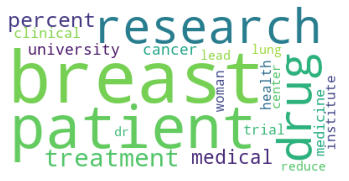

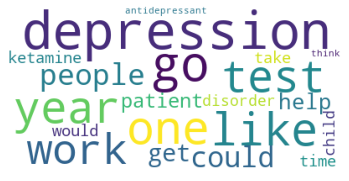

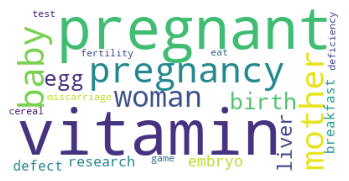

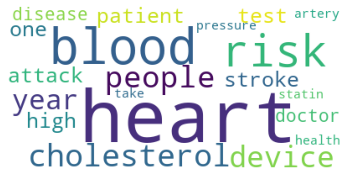

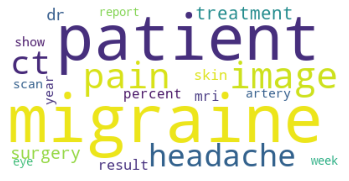

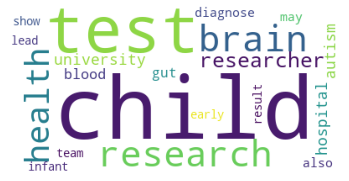

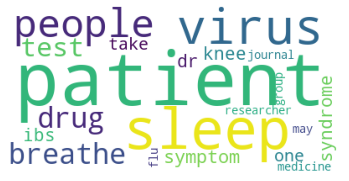

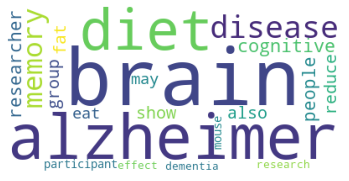

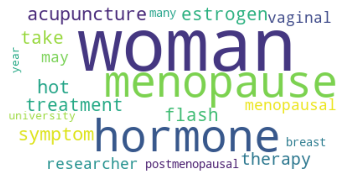

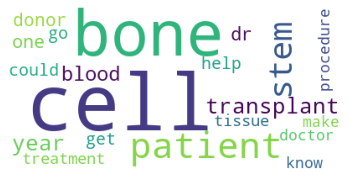

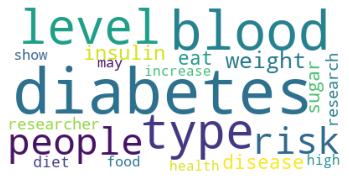

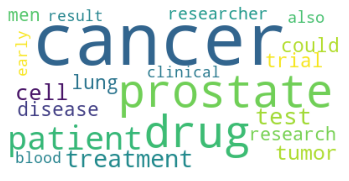

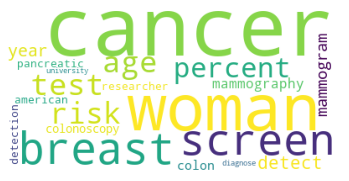

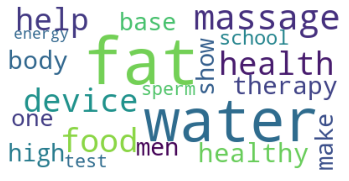

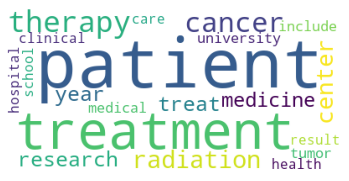

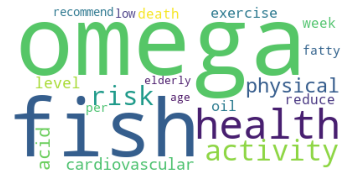

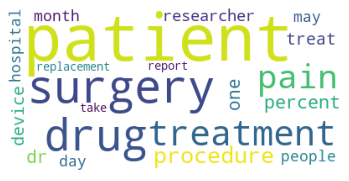

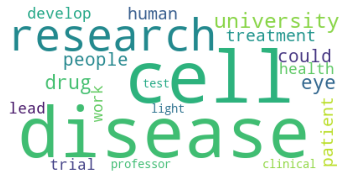

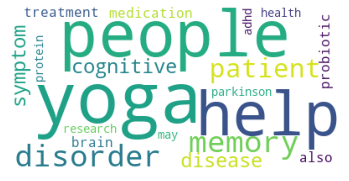

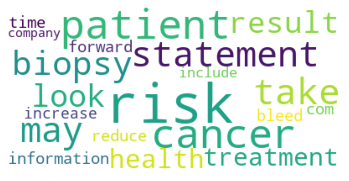

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
for t in range(20):
    plt.figure()
    plt.imshow(WordCloud(background_color="white").fit_words(dict(topic_model.show_topic(t, 20))))
    plt.axis("off")
    plt.savefig(f"T{t}.png")

In [ ]:
import pyLDAvis.gensim

In [ ]:
vis_data = pyLDAvis.gensim.prepare(topic_model,doc2bows, vocabulary)

In [ ]:
pyLDAvis.display(vis_data)

In [ ]:
# from gensim.models import CoherenceModel

# topics_range = range(4,30,1) # it will create a list whose min element is 4 and max element is 18, and is incremented by 2


# coherence_scores = []
# topics_nums = []

# for num_topic in topics_range:
#     lda_model = gensim.models.ldamodel.LdaModel(corpus=doc2bows, id2word=vocabulary, num_topics = num_topic, passes=20, random_state=42)
#     coherence_lda_model = CoherenceModel(model=lda_model, texts=cleaned_content, dictionary=vocabulary, coherence='c_v')
#     coherence_scores.append(coherence_lda_model.get_coherence())
#     topics_nums.append(num_topic)

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(topics_nums, coherence_scores, '-')

# plt.xlabel('Number of topics')
# plt.ylabel('Coherence scores')

In [ ]:
import csv
CONSTRAINT_TRAIN = pd.read_csv('../data/train.tsv', quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t')
CONSTRAINT_VAL = pd.read_csv('../data/val.tsv', quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t')
CONSTRAINT_TEST = pd.read_csv('../data/test.tsv', quoting=csv.QUOTE_NONE, error_bad_lines=False, sep='\t')

In [ ]:
constraint_train = [preprocess(text) for text in CONSTRAINT_TRAIN['tweet'].tolist()]
constraint_val = [preprocess(text) for text in CONSTRAINT_VAL['tweet'].tolist()]
constraint_test = [preprocess(text) for text in CONSTRAINT_TEST['tweet'].tolist()]

In [ ]:
constraint_train_bow = [vocabulary.doc2bow(doc) for doc in constraint_train]
constraint_val_bow = [vocabulary.doc2bow(doc) for doc in constraint_val]
constraint_test_bow = [vocabulary.doc2bow(doc) for doc in constraint_test]

constraint_data = constraint_train_bow + constraint_val_bow + constraint_test_bow

In [ ]:
import numpy as np
# topics and documents that are appeared
topics_ids = np.zeros((NUM_TOPICS))

for doc in constraint_data:
    topics = topic_model[doc]
    
    for topic_id, _ in topics:
        topics_ids[topic_id] += 1 

In [ ]:
top_n = 5
print(f'{top_n} appeared topics \n')
print(topics_ids)
print(np.argpartition(topics_ids,-top_n)[-top_n:])